In [1]:
# Imports & utils
import torch
import matplotlib.pyplot as plt

import sys
import os.path as osp
module_path = osp.abspath(osp.join('..', 'src'))
if module_path not in sys.path: sys.path.append(module_path)

In [2]:
# Use the Cora dataset from Planetoid dataset.
# Symmetrically normalize the transition matrix.
from datasets import load_data, transition_matrix
data = load_data('Cora', transform=transition_matrix())
data

Data(x=[2708, 1433], edge_index=[2, 13264], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_classes=7, edge_attr=[13264])

In [3]:
# Define the GNNGP model.
from gnngp import GNNGP
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNGP(data, L=2, sigma_b=0.0, sigma_w=1.0, device=device)
# Equivalently, use:
# model = GNNGP(data, device=device)
# model.set_hyper_param(L=2, sigma_b=0.0, sigma_w=1.0)

model.get_summary()
# Print the hyper parameters.
# By default, GNNGP will use the linear initial kernel and GCN method.

{'L': 2,
 'sigma_b': 0.0,
 'sigma_w': 1.0,
 'Nystrom': False,
 'initial': 'linear',
 'method': 'GCN'}

In [4]:
# Compute the GNNGP Kernel.
K = model.get_kernel()
K[:6, :6]

tensor([[2.1150, 1.6800, 1.5673, 1.2575, 0.8367, 1.0808],
        [1.6800, 5.0509, 3.3985, 2.0685, 1.2520, 1.7811],
        [1.5673, 3.3985, 3.1516, 1.8391, 1.1329, 1.6149],
        [1.2575, 2.0685, 1.8391, 4.7500, 0.9993, 1.5060],
        [0.8367, 1.2520, 1.1329, 0.9993, 1.3569, 1.0912],
        [1.0808, 1.7811, 1.6149, 1.5060, 1.0912, 2.7493]])

In [5]:
# Choose a range of epsilon (nugget) values for posterior inference.
# Then fitting data and compute the accuracy in one shot.
# This is enerally faster than loop over all choices of epsilon.
epsilon = torch.logspace(-3, 1, 101, device=model.device)
model.predict(epsilon)

model.get_summary()
# In the summary, the optimal epsilon (nugget) will be chosen based on val accuracy.

{'L': 2,
 'sigma_b': 0.0,
 'sigma_w': 1.0,
 'Nystrom': False,
 'initial': 'linear',
 'method': 'GCN',
 'nugget': tensor(0.1738),
 'train': tensor(1.),
 'val': tensor(0.7920),
 'test': tensor(0.8280)}

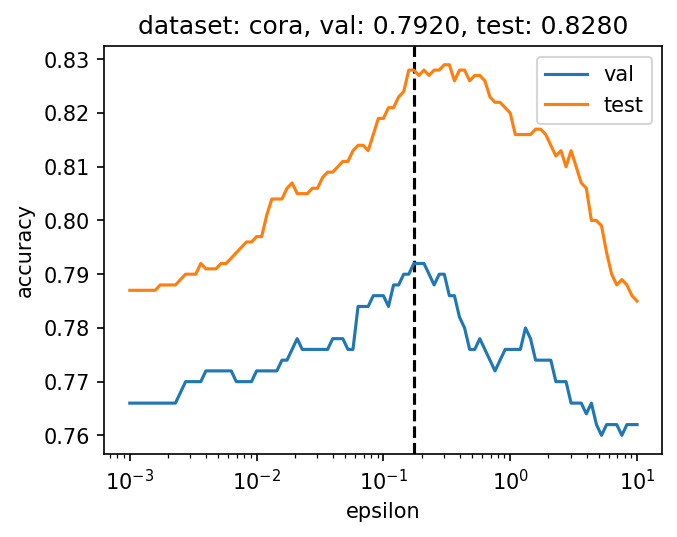

In [6]:
# Visualize the choice of epsilon (nugget)
result = model.result
i = torch.argmax(result["val"])
plt.figure(figsize=(4.8, 3.6), dpi=150)
plt.title("dataset: cora, val: %.4f, test: %.4f" % (result["val"][i], result["test"][i]))
plt.axvline(x=epsilon[i], linestyle="--", color='black')
plt.plot(epsilon, result["val"], label="val")
plt.plot(epsilon, result["test"], label="test")
plt.xscale("log"); plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.legend()

In [7]:
# Benchmark: GCN

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_features, 256, normalize=False)
        self.conv2 = GCNConv(256, data.num_classes, normalize=False)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1)

def train():
    model.train()
    optimizer.zero_grad()
    loss = F.nll_loss(model(data)[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

@torch.no_grad()
def test():
    model.eval()
    accs = []
    preds = model(data).argmax(dim=1)
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = torch.mean((preds[mask] == data.y[mask]).to(torch.float))
        accs.append(acc)
    return accs

torch.manual_seed(123)
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 101):
    train()
    train_acc, val_acc, test_acc = test()
    if epoch < 10 or epoch % 10 == 0:
        print("Epoch: %03d, train: %.4f, val: %.4f, test: %.4f" % 
                (epoch, train_acc, val_acc, test_acc))

Epoch: 001, train: 0.9643, val: 0.7080, test: 0.7190
Epoch: 002, train: 0.9714, val: 0.7520, test: 0.7670
Epoch: 003, train: 0.9786, val: 0.7840, test: 0.7920
Epoch: 004, train: 0.9857, val: 0.7940, test: 0.8090
Epoch: 005, train: 0.9857, val: 0.7920, test: 0.8150
Epoch: 006, train: 1.0000, val: 0.7880, test: 0.8130
Epoch: 007, train: 1.0000, val: 0.7840, test: 0.8090
Epoch: 008, train: 1.0000, val: 0.7820, test: 0.7950
Epoch: 009, train: 1.0000, val: 0.7820, test: 0.7880
Epoch: 010, train: 1.0000, val: 0.7820, test: 0.7840
Epoch: 020, train: 1.0000, val: 0.7600, test: 0.7740
Epoch: 030, train: 1.0000, val: 0.7600, test: 0.7790
Epoch: 040, train: 1.0000, val: 0.7600, test: 0.7760
Epoch: 050, train: 1.0000, val: 0.7600, test: 0.7740
Epoch: 060, train: 1.0000, val: 0.7600, test: 0.7740
Epoch: 070, train: 1.0000, val: 0.7600, test: 0.7750
Epoch: 080, train: 1.0000, val: 0.7600, test: 0.7750
Epoch: 090, train: 1.0000, val: 0.7580, test: 0.7750
Epoch: 100, train: 1.0000, val: 0.7580, test: 

In [9]:
# Benchmark: GGP kernel

data = load_data('Cora', transform=transition_matrix(normalization_in="row"))
params = {"initial":"polynomial", "c":5.0, "d":3.0}
model = GNNGP(data, method="GGP", device=device, **params)
model.predict(epsilon)

model.get_summary()

{'L': 2,
 'sigma_b': 0.1,
 'sigma_w': 1.0,
 'Nystrom': False,
 'initial': 'polynomial',
 'method': 'GGP',
 'nugget': tensor(1.0965),
 'train': tensor(1.),
 'val': tensor(0.7660),
 'test': tensor(0.7850)}